In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install trimesh
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import scipy.io
import logging
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import torchvision.transforms as transforms
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from torchvision.utils import make_grid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 10.7 MB/s eta 0:00:00 0:00:01


In [6]:
logging.basicConfig(level=logging.INFO)

class Pix3DJSONDataset(Dataset):
    def __init__(self, base_dir, json_file, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.data = self.load_json(json_file)

    def load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        logging.info(f"Loaded {len(data)} samples from JSON file")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load image
        img_path = os.path.join(self.base_dir, item['img'])
        image = self.load_image(img_path)
        
        # Load 3D model (as voxel)
        voxel_path = os.path.join(self.base_dir, item['voxel'])
        voxel = self.load_voxel(voxel_path)
        
        # Get category
        category = item['category']
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        voxel = torch.from_numpy(voxel).float()

        return image, voxel, category

    def load_image(self, path):
        try:
            with Image.open(path) as img:
                return img.convert('RGB')
        except Exception as e:
            logging.error(f"Error loading image {path}: {str(e)}")
            raise

    def load_voxel(self, path):
        try:
            voxel_data = scipy.io.loadmat(path)
            voxel = voxel_data['voxel'].astype(np.float32)
            return voxel
        except Exception as e:
            logging.error(f"Error loading voxel {path}: {str(e)}")
            raise



In [7]:
# Define transforms
transform = transforms.Compose([
#         transforms.Grayscale(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
base_dir = '/kaggle/input/pix3d-dataset'
json_file = '/kaggle/input/pix3d-dataset/pix3d.json'  # Adjust this path as needed
dataset = Pix3DJSONDataset(base_dir, json_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [9]:
# Print some information about the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Try to get the first batch
first_batch = next(iter(dataloader))
print(f"First batch shapes:")
print(f"  Images: {first_batch[0].shape}")
print(f"  Voxels: {first_batch[1].shape}")
print(f"First batch categories: {first_batch[2]}")


Dataset size: 10069
Number of batches: 10069
First batch shapes:
  Images: torch.Size([1, 3, 128, 128])
  Voxels: torch.Size([1, 128, 128, 128])
First batch categories: ('chair',)


In [10]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [11]:
def downsample_volume(volume, scale_factor=0.5):
    downsampled = F.interpolate(volume, scale_factor=scale_factor, mode='nearest')
    return downsampled.squeeze()

In [12]:
# Matplotlib visualization (faster, simplified)
def get_volume_views(volume, downsample=True, scale_factor=0.5):
    if downsample:
        volume = downsample_volume(volume, scale_factor)
    volume = volume.squeeze().detach().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(volume, edgecolor='k')  # No edges for faster rendering
    
    # Save or display
    plt.show()
    plt.close()


In [13]:
for batch in dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128, 128])


In [ ]:
show_tensor_images(batch[0][0])

In [ ]:
get_volume_views(batch[1][0], downsample=True, scale_factor=0.25)

In [14]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2,last=False):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride,1),
                nn.BatchNorm2d(out_channels) if not last else nn.Identity(),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=32):
        super().__init__()
        self.d1=CNN_Block(in_channels+128,hidden_dim)
        self.d2=CNN_Block(hidden_dim,hidden_dim*2)
        self.d3=CNN_Block(hidden_dim*2,hidden_dim*4)
        self.d4=CNN_Block(hidden_dim*4,hidden_dim*8)
        self.d5=CNN_Block(hidden_dim*8,hidden_dim*8)
        self.d6=CNN_Block(hidden_dim*8,hidden_dim*16)
        self.d7=CNN_Block(hidden_dim*16,1,last=True)
        
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)
        x=self.d1(x)
        x=self.d2(x)        
        x=self.d3(x)        
        x=self.d4(x)        
        x=self.d5(x)
        x=self.d6(x)
        x=self.d7(x)
        x=torch.squeeze(x)
        return x

In [95]:
disc=Discriminator()

In [36]:
d3=batch[1].unsqueeze(1)

In [37]:
d2=batch[0].unsqueeze(-1)

In [28]:
d2=d2.repeat(1,1,1,1,128)

In [38]:
print(d2.shape)
print(d3.shape)

torch.Size([1, 3, 128, 128, 1])
torch.Size([1, 1, 128, 128, 128])


In [30]:
combined_input = torch.cat((d2, d3), dim=1)

In [34]:
d2[0][0].shape

torch.Size([128, 128, 128])

In [97]:
disc(batch[0],batch[1]).item()

-0.03868498280644417

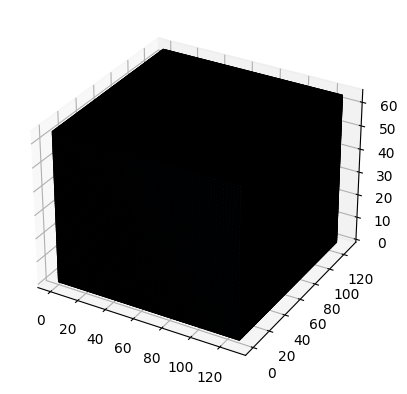

In [35]:
get_volume_views(d2[0][0])

In [16]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False,norm=True):
        super().__init__()
        self.drop=drop
        self.norm=norm
        self.dropout=nn.Dropout(0.5)
        if self.norm==True:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.BatchNorm2d(out_channels) if down else nn.BatchNorm3d(out_channels),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
        else:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
            
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [17]:
class Generator(nn.Module):
    def __init__(self,hidden_dim=32,in_channels=3):
        super(Generator,self).__init__() 
        self.down1=Block(in_channels,hidden_dim,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down3=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down7=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False,norm=False)
 
        self.bottleneck=nn.Sequential(
            nn.Conv3d(hidden_dim*8,hidden_dim*8,3,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up4=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)
        self.up5=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)
        self.up6=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)
        self.up7=Block(hidden_dim*2,1,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose3d(hidden_dim*2,in_channels,4,2,1),
            nn.Tanh()
        )
        
    def forward(self,x):
        d1=self.down1(x)
#         print("down1: ",d1.shape) #[BATCH_SIZE,32,64,64]
        d2=self.down2(d1)
#         print("down2: ",d2.shape) #[BATCH_SIZE,64,32,32]
        d3=self.down3(d2)
#         print("down3: ",d3.shape) #[BATCH_SIZE,128,16,16]
        d4=self.down4(d3)
#         print("down4: ",d4.shape) #[BATCH_SIZE,256,8,8]
        d5=self.down5(d4)
#         print("down5: ",d5.shape) #[BATCH_SIZE,256,4,4]
        d6=self.down6(d5)
#         print("down6: ",d6.shape) #[BATCH_SIZE,256,2,2]
        d7=self.down7(d6)
#         print("down7: ",d7.shape) #[BATCH_SIZE,256,1,1]
        

        d7_resh=d7.view(-1,256,1,1,1)
#         print("down7 reshaped: ",d7_resh.shape) #[BATCH_SIZE,256,1,1,1]
#         print("="*50)

        bottleneck=self.bottleneck(d7_resh)
#         print("bottleneck: ",bottleneck.shape) #[BATCH_SIZE, 256, 1, 1, 1]
        
#         print("="*50)
        
        up1=self.up1(torch.cat([bottleneck,d7_resh],dim=1))
#         print("up1: ",up1.shape) #[BATCH_SIZE, 256, 2, 2, 2]
        
        d6_resh=d6.view(-1,256,2,2,1).repeat(1,1,1,1,2)
        up2=self.up2(torch.cat([up1,d6_resh],dim=1))
#         print("up2: ",up2.shape) #[BATCH_SIZE, 256, 4, 4, 4]
        d5_resh=d5.view(-1,256,4,4,1).repeat(1,1,1,1,4)
        up3=self.up3(torch.cat([up2,d5_resh],dim=1))
#         print("up3: ",up3.shape) #[BATCH_SIZE, 256, 8, 8, 8]
        d4_resh=d4.view(-1,256,8,8,1).repeat(1,1,1,1,8)
        up4=self.up4(torch.cat([up3,d4_resh],dim=1))
#         print("up4: ",up4.shape) #[BATCH_SIZE, 128, 16, 16, 16]
        d3_resh=d3.view(-1,128,16,16,1).repeat(1,1,1,1,16)
        up5=self.up5(torch.cat([up4,d3_resh],dim=1))
#         print("up5: ",up5.shape) #[BATCH_SIZE, 64, 32, 32, 32]
        d2_resh=d2.view(-1,64,32,32,1).repeat(1,1,1,1,32)
        up6=self.up6(torch.cat([up5,d2_resh],dim=1))
#         print("up6: ",up6.shape) #[BATCH_SIZE, 32, 64, 64,64]
        d1_resh=d1.view(-1,32,64,64,1).repeat(1,1,1,1,64)
        up7=self.up7(torch.cat([up6,d1_resh],dim=1))
#         print("up7: ",up7.shape) #[BATCH_SIZE, 1, 128,128, 128]
        
        return up7.squeeze(0)
#         return up7

In [41]:
gen=Generator()

In [43]:
gen(batch[0]).shape

torch.Size([1, 128, 128, 128])

In [32]:
class net_D(torch.nn.Module):
    def __init__(self):
        super(net_D, self).__init__()
#         self.args = args
        self.cube_len = 128
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.f_dim = 32

        self.layer1 = self.conv_layer(1, self.f_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer2 = self.conv_layer(self.f_dim, self.f_dim*2, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer3 = self.conv_layer(self.f_dim*2, self.f_dim*4, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer4 = self.conv_layer(self.f_dim*4, self.f_dim*8, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer5=self.conv_layer(self.f_dim*8, self.f_dim*8, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer6=self.conv_layer(self.f_dim*8, self.f_dim*8, kernel_size=3, stride=2, padding=(1,1,1), bias=self.bias)
#         self.layer8=self.conv_layer(self.f_dim*8, 1, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)


        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv3d(self.f_dim*8, 1, kernel_size=2, stride=2, bias=self.bias, padding=padd),
#             torch.nn.Sigmoid()
        )

    def conv_layer(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False):
        layer = torch.nn.Sequential(
            torch.nn.Conv3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            torch.nn.BatchNorm3d(output_dim),
            torch.nn.LeakyReLU(self.leak_value, inplace=True)
        )
        return layer

    def forward(self, x):
        # out = torch.unsqueeze(x, dim=1)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
        # print(out.size()) # torch.Size([32, 1, 32, 32, 32])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        # out = out.view(-1, 256*2*2*2)
        # print (out.size())
        out=self.layer5(out)
#         print(out.shape)
        out=self.layer6(out)
#         print(out.shape)
        out = self.layer7(out)
#         print(out.size())  # torch.Size([32, 1, 1, 1, 1])
        out = torch.squeeze(out)
        return out

In [19]:
disc2=net_D()

In [114]:
disc2(batch[1])

torch.Size([1, 256, 4, 4, 4])
torch.Size([1, 256, 2, 2, 2])
torch.Size([1, 1, 1, 1, 1])


tensor(-0.2084, grad_fn=<SqueezeBackward0>)

In [34]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [35]:
gen=Generator().cuda()
disc=Discriminator().cuda()
disc2=net_D().cuda()

In [36]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
disc2=disc2.apply(weights_init)

In [37]:
LR=0.0002
BETAS=(0.5,0.999)
LAMBDA=100
EPOCHS=10

In [38]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)
disc2_opt=torch.optim.Adam(disc2.parameters(),lr=LR,betas=BETAS)

In [39]:
BCE_Loss=nn.BCEWithLogitsLoss()
L1_Loss=nn.L1Loss()

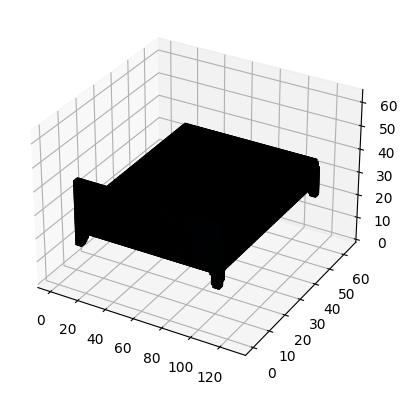

In [48]:
get_volume_views(batch[1])

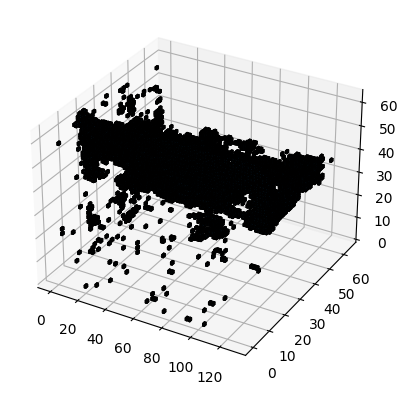

In [47]:
gen=gen.cpu()
get_volume_views(gen(batch[0]))

In [45]:
gen=gen.cuda()

In [46]:
for epoch in range(10):
    for batch in tqdm(dataloader):
        image_2d=batch[0].cuda()
        image_3d=batch[1].cuda()
        fake_3d=gen(image_2d)
#         ========Train Disc2
#         D2_real=disc2(fake_3d)
#         D2_loss=BCE_Loss(D2_real,torch.ones_like(D2_real))

#         disc2.zero_grad()
#         D2_loss.backward(retain_graph=True)
#         disc2_opt.step()
#         ========  
#         ========Train Disc1
        D1_real=disc(image_2d,image_3d)
        D1_real_loss=BCE_Loss(D1_real,torch.ones_like(D1_real))
        D1_fake=disc(image_2d,fake_3d)
        D1_fake_loss=BCE_Loss(D1_fake,torch.zeros_like(D1_fake))
        D1_loss=(D1_real_loss+D1_fake_loss)/2
        disc.zero_grad()
        D1_loss.backward(retain_graph=True)
        disc_opt.step()
#         ======== 
#         ========Train Gen
        D1_fake=disc(image_2d,fake_3d)
        G_fake_loss1=BCE_Loss(D1_fake,torch.ones_like(D1_fake))
#         G_fake_loss2=BCE_Loss(D2_real)
        L1=L1_Loss(fake_3d,image_3d)*LAMBDA
        G_loss=G_fake_loss1+L1
        gen.zero_grad()
        G_loss.backward()
        gen_opt.step()
        

  0%|          | 0/10069 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/10069 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/10069 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
gen_PATH='/kaggle/working/gen_3'
disc_PATH='/kaggle/working/disc_3'
torch.save(disc.state_dict(), disc_PATH)
torch.save(gen.state_dict(), gen_PATH)